<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Grid-search" data-toc-modified-id="Grid-search-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Grid search</a></span></li><li><span><a href="#Random-search" data-toc-modified-id="Random-search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random search</a></span></li><li><span><a href="#Bayesian-search" data-toc-modified-id="Bayesian-search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian search</a></span><ul class="toc-item"><li><span><a href="#Gaussian-Process-Regression" data-toc-modified-id="Gaussian-Process-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gaussian Process Regression</a></span></li><li><span><a href="#Bayesian-search" data-toc-modified-id="Bayesian-search-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Bayesian search</a></span></li></ul></li></ul></div>

In [1]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

N_train=10

np.random.seed(0)
X_train = np.random.rand(N_train, 1)
y_train = X_train[:,0] + np.random.randn(N_train)
X_test = np.random.rand(10, 1)
y_test = X_test[:,0] + np.random.randn(N_train)

# Grid search

minimum value 1.16E+00
minimum at    3.71E-01


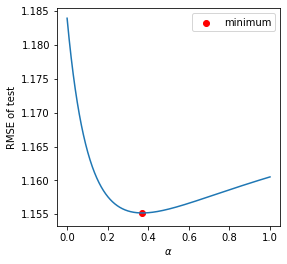

In [2]:
alpha_max = 1

alphas = np.linspace(0, alpha_max, 1000)
mses = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, lr.predict(X_test))
    mses[i] = mse


def plot_mse(alphas, mses):
    alphas=np.array(alphas)
    mses=np.array(mses)
    index = np.argsort(alphas)
    alphas = alphas[index]
    mses = mses[index]
    
    plt.figure(figsize=(4,4))
    argmin = np.argmin(mses)
    print("minimum value %.2E"%mses[argmin])
    print("minimum at    %.2E"%alphas[argmin])

    plt.plot(alphas, mses)
    plt.scatter([alphas[argmin]], [mses[argmin]], color="red", label="minimum")
    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"RMSE of test")
    plt.legend()
    plt.show()
    
plot_mse(alphas, mses)

minimum value 1.16E+00
minimum at    3.33E-01


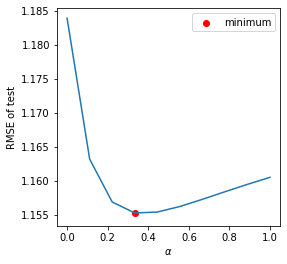

In [3]:
alpha_max = 1

alphas = np.linspace(0, alpha_max, 10)
mses = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, lr.predict(X_test))
    mses[i] = mse

    
plot_mse(alphas, mses)

# Random search

minimum value 1.16E+00
minimum at    3.64E-01


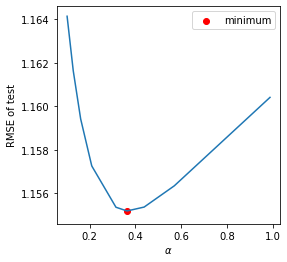

In [4]:
alphas = np.zeros(10)
mses = np.zeros(alphas.shape)

for i in range(10):
    alpha = np.random.rand(1) * alpha_max
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, lr.predict(X_test))
    mses[i] = mse
    alphas[i] = alpha

plot_mse(alphas, mses)

# Bayesian search

## Gaussian Process Regression

In [5]:

class RBF:
    '''
    kij = exp(-(d(xi, xj))^2/(2 l^2))
    '''
    def __init__(self, length_scale = 1.0, sigma = 1.):
        self.length_scale = length_scale
        self.sigma = 1.
        
    def __call__(self, X, Y=None):
        '''
        (X.shape[0], X.shape[1])
        '''
        if Y is None:
            Y = X
            
        distance2 = np.square(X[:,np.newaxis,:] - Y[np.newaxis,:,:]).sum(axis=2)
        distance2 /= 2*self.length_scale**2
        K = np.exp(-distance2)
        K *= self.sigma
        return K
        
def Zero(X):
    return np.zeros(X.shape[0])
        
class GaussianProcessRegressor:
    
    def __init__(self, m = None, kernel=None, alpha=1E-10):
        
        if kernel is None:
            kernel = RBF(length_scale = 1.0, sigma = 1.0)
            
        self.kernel = kernel
        
        if m is None:
            m = Zero
            
        self.m = m
        
        self.alpha = alpha
        
    def fit(self, X, y):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        X = np.array(X, dtype=np.float_)
        y = np.array(y, dtype=np.float_)
        
        y = y - self.m(X)
        KXX = self.kernel(X, X)
        if self.alpha != 0:
            KXX += self.alpha * np.eye(X.shape[0])
            
        invKXX = np.linalg.inv(KXX)
        weights = invKXX.dot(y)
        
        self.X = X
        self.y = y
        self.invKXX = invKXX
        self.coef_ = weights
        
        
    def predict(self, X, return_std=False):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        X = np.array(X, dtype=np.float_)
        
        Y = X
        X = self.X
        KXY = self.kernel(X, Y)
        f = KXY.T.dot(self.coef_) + self.m(Y)
        
        if not return_std:
            return f
        
        invKXX =  self.invKXX        
        KYY = self.kernel(Y, Y)
        KYX =  KXY.T
        KYY_post = KYY - KYX.dot( invKXX.dot(KXY) )
        return f, np.sqrt(np.maximum(0, np.diagonal(KYY_post)))
        
        

## Bayesian search

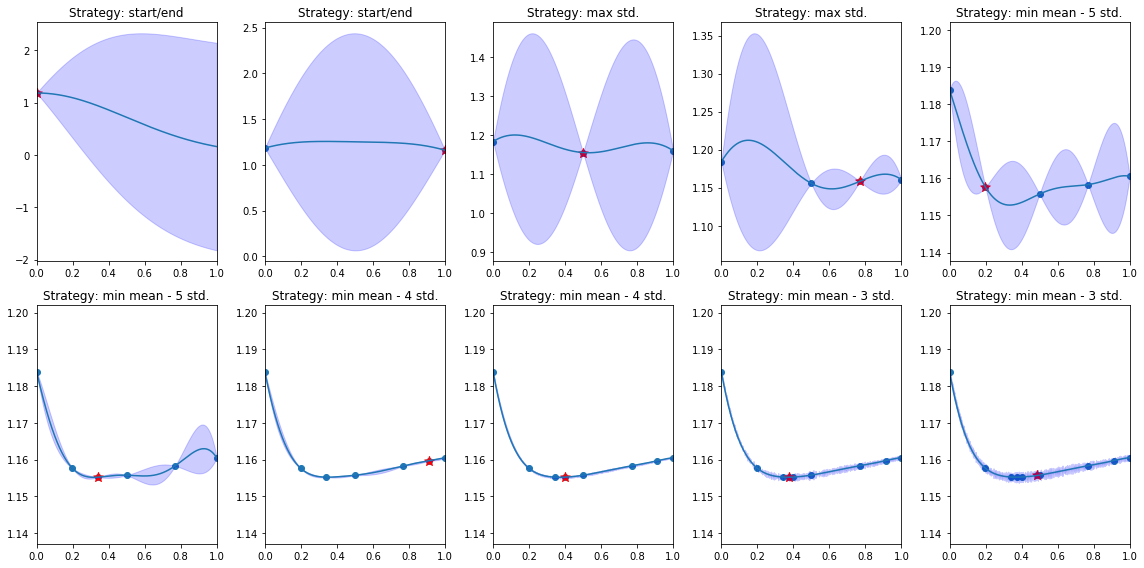

minimum value 1.16E+00
minimum at    3.75E-01


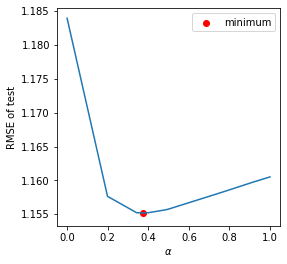

In [6]:
alphas = []
mses = []
X_plt = np.linspace(0, alpha_max, 1000)
rbf=RBF(0.5, 1)
gpr=GaussianProcessRegressor(kernel=rbf, alpha=2E-5**2)
        
fig, axes = plt.subplots(2, 5, figsize=(16,8))
for i in range(10):
    if i < 2:
        alpha = [0, alpha_max][i]
        title = "start/end"
    elif i < 4:
        argmin = np.argmin(-std_plt)
        alpha = X_plt[argmin]
        title = "max std."
    elif i < 6:
        argmin = np.argmin(y_plt - 5*std_plt)
        alpha = X_plt[argmin]
        title = "min mean - 5 std."
    elif i < 8:
        argmin = np.argmin(y_plt - 4*std_plt)
        alpha = X_plt[argmin]
        title = "min mean - 4 std."
    else:
        title = "min mean - 3 std."
        argmin = np.argmin(y_plt - 5*std_plt)
        alpha = X_plt[argmin]

    lr = Ridge(alpha)
    lr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, lr.predict(X_test))
    
    alphas.append(alpha)
    mses.append(mse)
    
    gpr.fit(np.array(alphas).reshape(-1,1), np.array(mses))

    ax = axes[i//5][i%5]
    ax.set_title("Strategy: " + title)
    ax.set_xlim((0, alpha_max))
    ax.scatter(alphas, mses)
    ax.scatter([alpha], [mse], marker="*", s=100, color="red")
    y_plt, std_plt = gpr.predict(X_plt.reshape(-1,1), return_std=True)
    ax.plot(X_plt, y_plt)
    ax.fill_between(X_plt, y_plt-2*std_plt, y_plt+2*std_plt, alpha=0.2, color="blue")

plt.tight_layout()
plt.show()
plot_mse(alphas, mses)